In [88]:
# Validate learned results
%load_ext autoreload
%autoreload 2
import numpy as np_force
import scipy as sc_force
import autograd.numpy as np
import autograd.scipy as sc
from autograd import grad, elementwise_grad, value_and_grad, grad_and_aux
from matplotlib import pyplot as plt
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import autogradLenslets_utils as ag_utils



import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


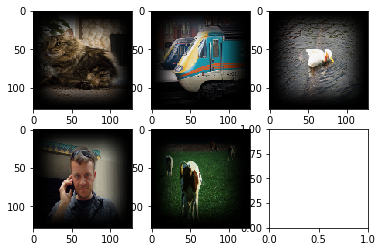

In [2]:
# Load images
samples = (64,64)
Ntrain = 20
Nbatch = 5
Nval = 5
dataset_dir = '/Users/nick.antipa/Documents/TrainingData/NaturalImages512/'

train_list, val_list = ag_utils.load_training_ims(samples, dataset_dir, Ntrain, Nbatch, Nval)

# Display some of the training data
subrows = int(np.floor(np.sqrt(Nval)))
subcols = int(np.ceil(np.sqrt(Nval)))
fig, ax = plt.subplots(subrows, subcols)#, figsize=(20,20))
c = -1
for n in range(subrows):
    for m in range(subcols):
        c += 1
        if c < Nval:
            ax[n,m].imshow(np.moveaxis(val_list[c], 0, -1))

In [8]:
# Load learned params
lrn = np.load('../learned_params_tau_lenslets_stepsize2_reallygood.npz')
print([lrn.keys()])

xrng = (-1,1)
yrng = (-1,1)
xg = np.linspace(xrng[0], xrng[1], samples[0])
yg = np.linspace(yrng[0], yrng[1], samples[1])
xg, yg = np_force.meshgrid(xg,yg)
ca = .9
ps = (xrng[1] - xrng[0])/samples[0]
fx = np.linspace(-1/2/ps,1/2/ps,samples[1])
fy = np.linspace(-1/2/ps,1/2/ps, samples[0])
Fx, Fy = np.meshgrid(fx,fy)
aperR = np.sqrt(xg**2 + yg**2)<ca


imnormalize = lambda x:x/np.max(x)
def rgb2imshow(im):
    return imnormalize(np.maximum(np.moveaxis(im,0,-1),0))

[['x_list_init', 'y_list_init', 'R_init', 'tau_init', 'mu1_init', 'mu2_init', 'mu3_init', 'x_list_learn', 'y_list_learn', 'curvature_list_learn', 'tau_learn', 'mu1_learn', 'mu2_learn', 'mu3_learn', 'x_list_best', 'y_list_best', 'R_lenslets_best', 'ca', 'lamb_mm', 'N_lenslets_learning', 'tau_best', 'mu1_best', 'mu2_best', 'mu3_best', 'prop_distance', 'ior_lenslets', 'recon_iters', 'step_size_2', 'step_size_lenslets', 'step_size_mu', 'step_size_tau', 'validation_cost', 'ss_scale', 'mu_min', 'tau_min']]


In [9]:
# Simulate measurement
x_b = lrn['x_list_best']
y_b = lrn['y_list_best']
c_b = lrn['R_lenslets_best']
mu1_b = lrn['mu1_best']
mu2_b = lrn['mu2_best']
mu3_b = lrn['mu3_best']
tau_b = lrn['tau_best']

x = lrn['x_list_learn']
y = lrn['y_list_learn']
c = lrn['curvature_list_learn']
mu1 = lrn['mu1_learn']
mu2 = lrn['mu2_learn']
mu3 = lrn['mu3_learn']
tau = lrn['tau_learn']

x_i = lrn['x_list_init']
y_i = lrn['y_list_init']
c_i = lrn['R_init']
mu1_i = lrn['mu1_init']
mu2_i = lrn['mu2_init']
mu3_i = lrn['mu3_init']
tau_i = lrn['tau_init']


ior = lrn['ior_lenslets']
z = lrn['prop_distance']
lamb = lrn['lamb_mm']
ca = lrn['ca']
iters = lrn['recon_iters']

0
1
2
3
4


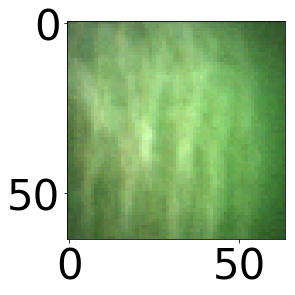

In [143]:
recon_b = []
recon_i = []
recon_ladmm = []
recon_opt = []
loss_b = []
loss_i = []
loss_ladmm = []
loss_opt = []
loss_m = []
recon_m = []
tau_m = 5e-4 #np.mean(tau_b[-1])
iters_m = 200
mu1_m = np.mean(mu1_b)
mu2_m = np.mean(mu2_b)
mu3_m = np.mean(mu3_b)


meas_noise = .005
for nn in range(len(val_list)):
    lslet_b = ag_utils.make_lenslet_surface_ag(x_b, y_b, c_b, xg, yg, mode='curvature')
    psf_b = ag_utils.gen_psf_ag(lslet_b, ior, z, 'inf', 'angle', (0., 0.), ca, lamb, xg, yg, Fx, Fy, prop_pad = .2)
    meas_b = ag_utils.forward_sim(psf_b, val_list[nn], noise_var = meas_noise)
    recon_b.append([ag_utils.admm2d_learn(np.squeeze(meas_b[n,:,:]),psf_b,tau_b, iters, mu1_b, mu2_b, mu3_b, options = ag_utils.gen_options()) for n in range(meas_b.shape[0])])
    loss_b.append(np.linalg.norm((recon_b[nn]-val_list[nn]).ravel()))
    
    lslet_i = ag_utils.make_lenslet_surface_ag(x_i, y_i, c_i, xg, yg, mode='curvature')
    psf_i = ag_utils.gen_psf_ag(lslet_i, ior, z, 'inf', 'angle', (0., 0.), ca, lamb, xg, yg, Fx, Fy, prop_pad = .2)
    meas_i = ag_utils.forward_sim(psf_i, val_list[nn], noise_var = meas_noise)
    
    recon_i.append([ag_utils.admm2d_learn(np.squeeze(meas_i[n,:,:]),psf_i,tau_i, iters, mu1_i, mu2_i, mu3_i, options = ag_utils.gen_options()) for n in range(meas_i.shape[0])])
    recon_ladmm.append([ag_utils.admm2d_learn(np.squeeze(meas_i[n,:,:]),psf_i,tau_b, iters, mu1_b, mu2_b, mu3_b, options = ag_utils.gen_options()) for n in range(meas_i.shape[0])])
    recon_opt.append([ag_utils.admm2d_learn(np.squeeze(meas_b[n,:,:]),psf_b,tau_i, iters, mu1_i, mu2_i, mu3_i, options = ag_utils.gen_options()) for n in range(meas_i.shape[0])])
    
    loss_i.append(np.linalg.norm((recon_i[nn]-val_list[nn]).ravel()))
    loss_ladmm.append(np.linalg.norm((recon_ladmm[nn]-val_list[nn]).ravel()))
    loss_opt.append(np.linalg.norm((recon_opt[nn]-val_list[nn]).ravel()))
    
    recon_m.append([ag_utils.admm2d(np.squeeze(meas_b[n,:,:]),psf_b,tau_m, iters_m, options = ag_utils.gen_options(mu1 = mu1_m, mu2 = mu2_m, mu3 = mu3_m)) for n in range(meas_i.shape[0])])
    loss_m.append(np.linalg.norm((recon_m[nn]-val_list[nn]).ravel()))
    print(nn)
    
plt.figure()
plt.imshow(rgb2imshow(meas_i))


0.0004
0.0005
0.0006
[9.417371120127116, 9.345707750067955, 9.347267642839673]


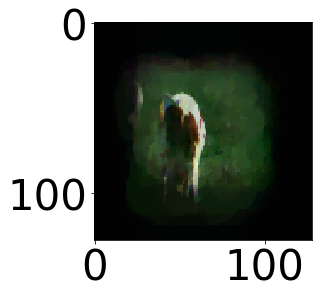

In [142]:
recon_tau = []
loss_tau = []
nn = 0
taucount = 0
for tau_test in [4e-4, 5e-4, 6e-4]:
    recon_tau.append([ag_utils.admm2d(np.squeeze(meas_b[n,:,:]),psf_b,tau_test, iters_m, options = ag_utils.gen_options(mu1 = mu1_m, mu2 = mu2_m, mu3 = mu3_m)) for n in range(meas_i.shape[0])])
    loss_tau.append(np.linalg.norm((recon_tau[taucount]-val_list[-1]).ravel()))
    taucount += 1
    print(tau_test)
    
print(loss_tau)
plt.imshow(rgb2imshow(recon_tau[0]))

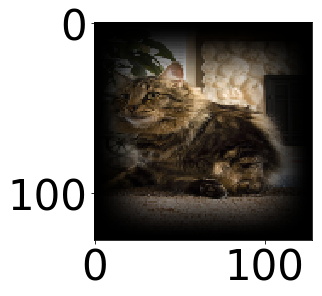

In [136]:
plt.imshow(rgb2imshow(val_list[nn]))

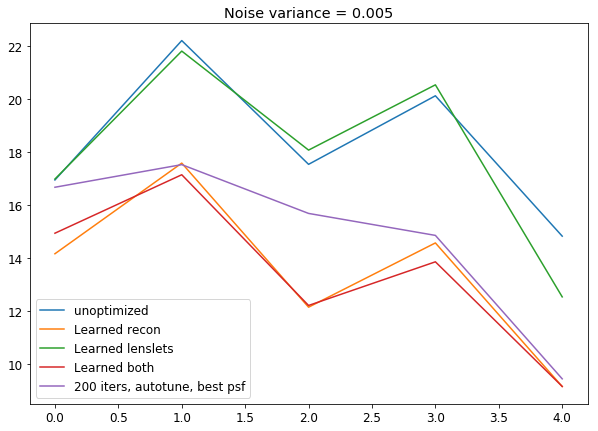

In [144]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.figure(figsize = (10,7))

plt.plot(loss_i,label='unoptimized')
plt.plot(loss_ladmm,label='Learned recon')
plt.plot(loss_opt,label='Learned lenslets')
plt.plot(loss_b,label='Learned both')
plt.plot(loss_m, label = '200 iters, autotune, best psf')
plt.title('Noise variance = %.3f' %meas_noise)
plt.legend()

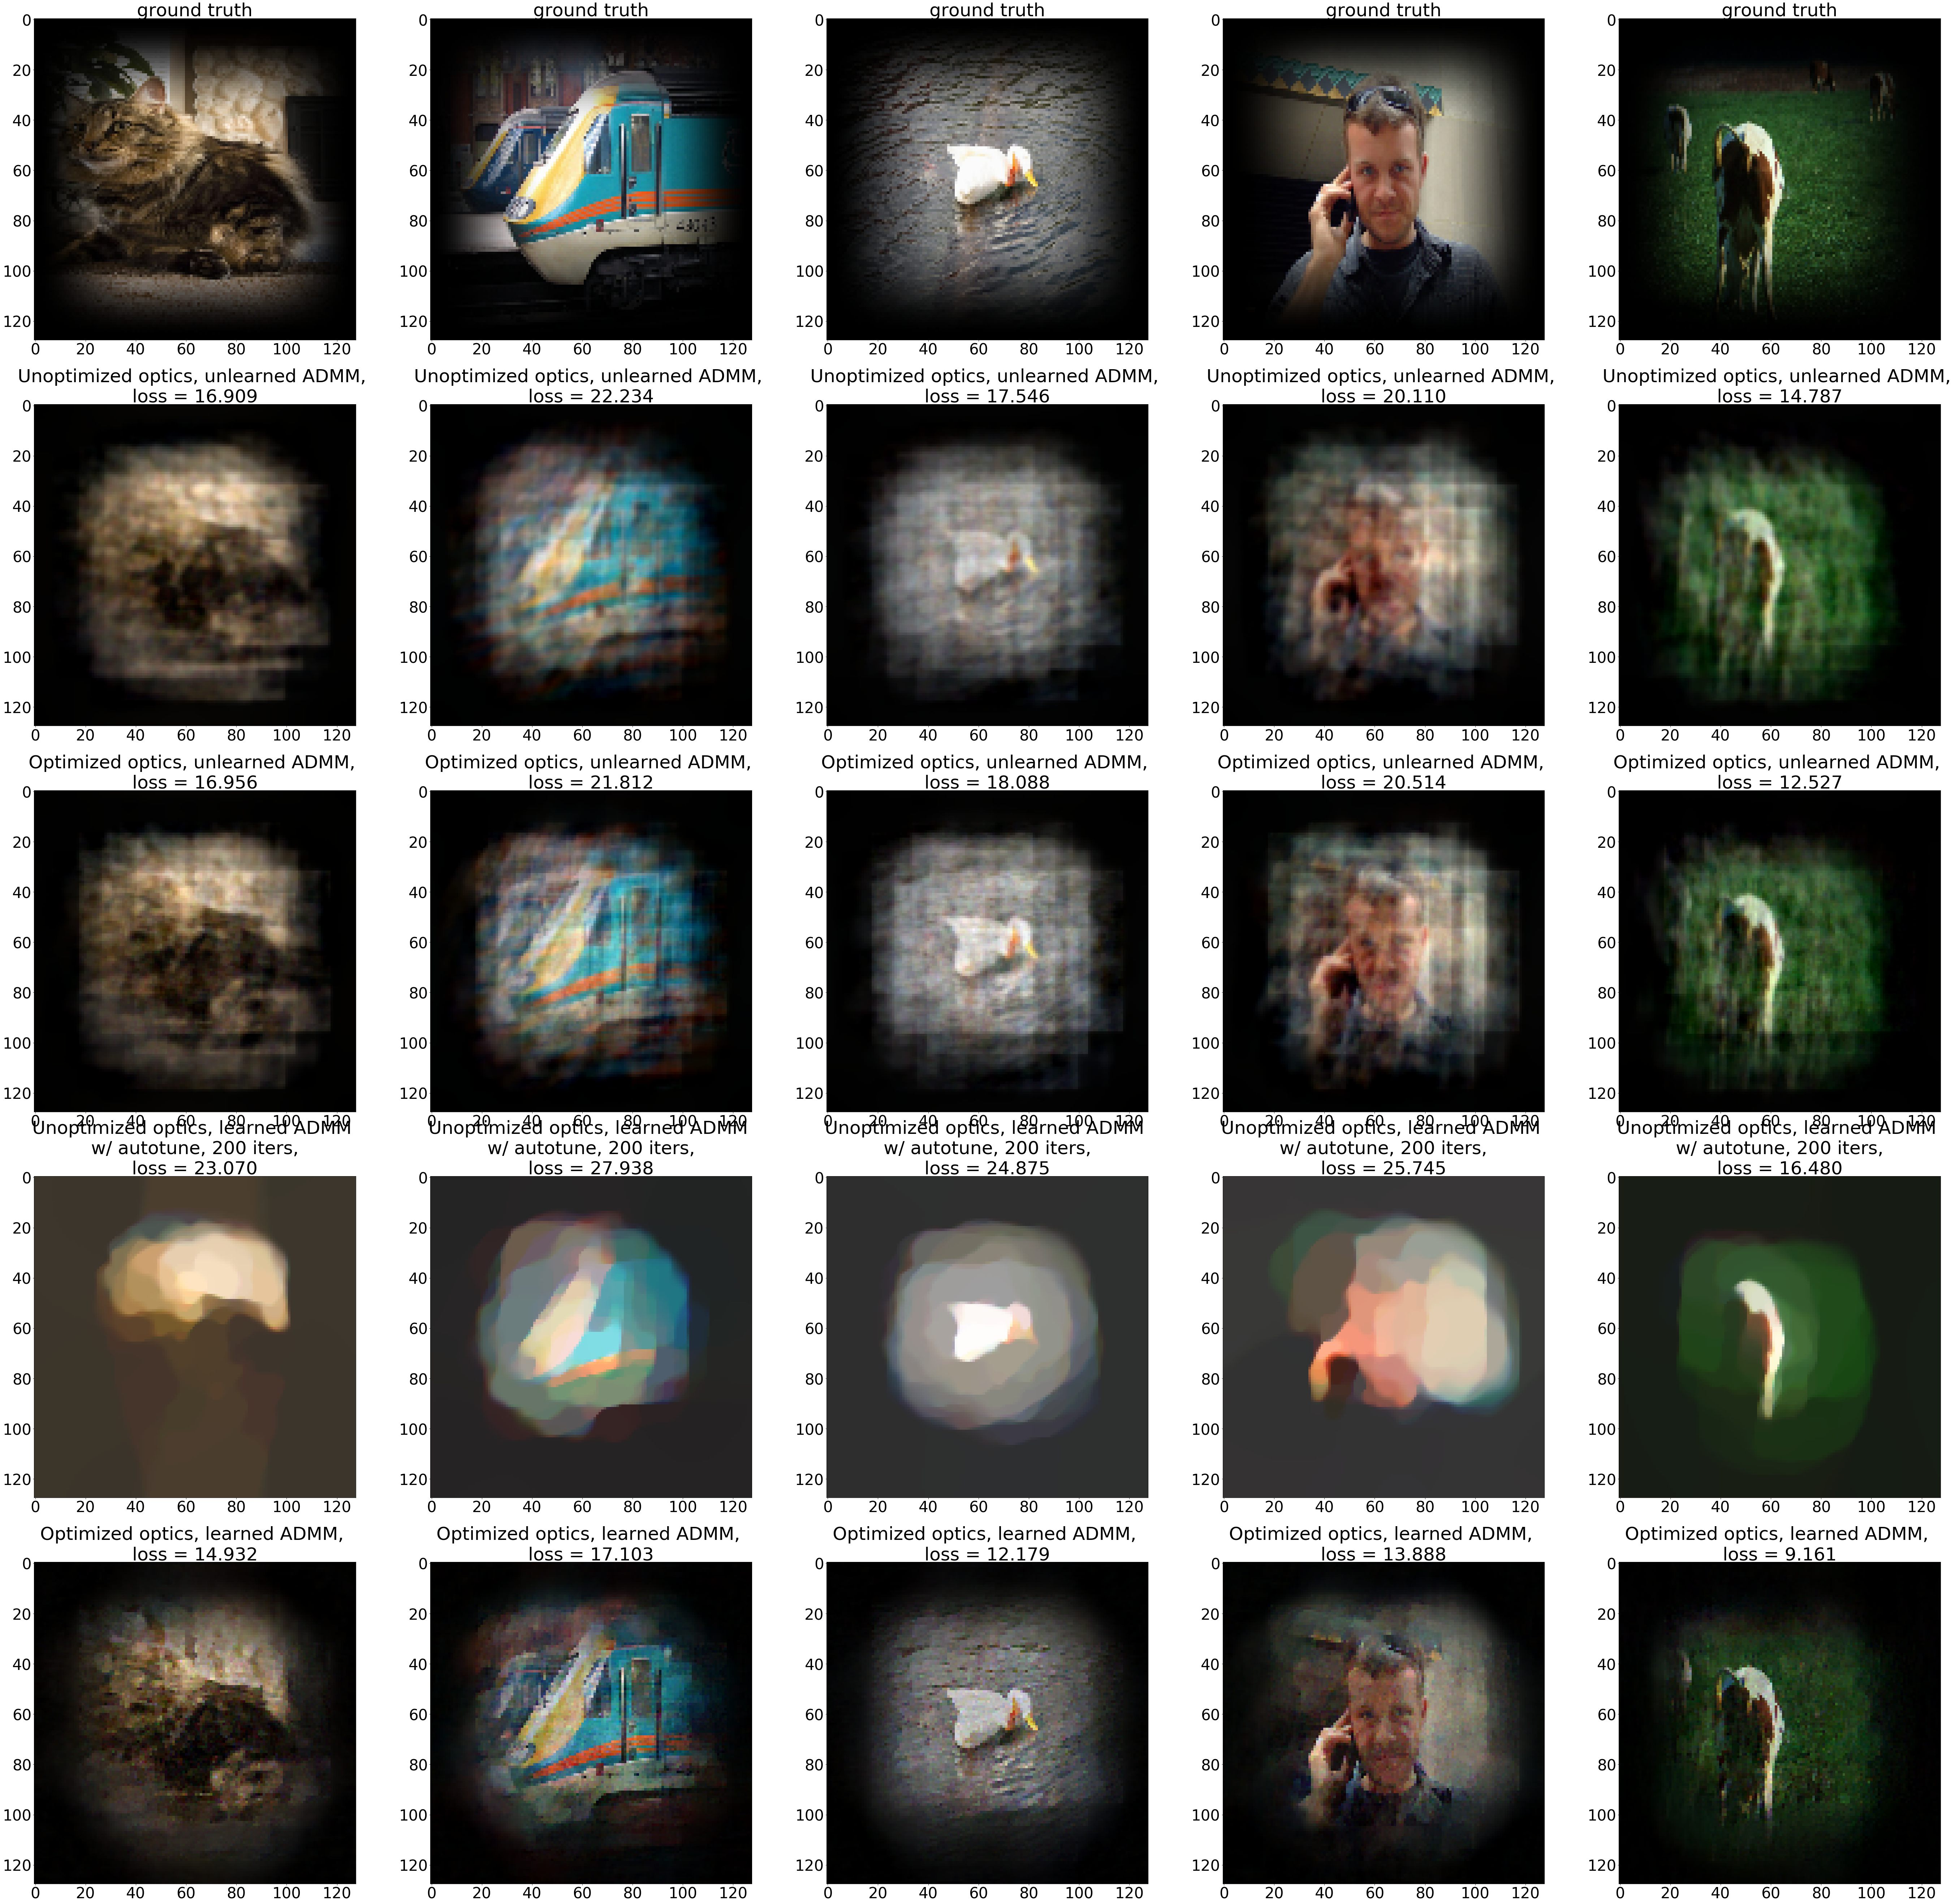

In [133]:
fs = 19
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 42}

plt.rc('font', **font)
fig, ax = plt.subplots(5,len(val_list), figsize = (fs*len(val_list), fs*5))
for nn in range(len(val_list)):
    ax[0,nn].imshow(rgb2imshow(val_list[nn]))
    ax[0,nn].set_title('ground truth')
    ax[1,nn].imshow(rgb2imshow(recon_i[nn]))
    ax[1,nn].set_title('Unoptimized optics, unlearned ADMM, \nloss = %.3f' %loss_i[nn])
    ax[3,nn].imshow(rgb2imshow(recon_m[nn]))
    ax[3,nn].set_title('Unoptimized optics, learned ADMM \n w/ autotune, %i iters, \nloss = %.3f' %(iters_m,loss_m[nn]))
    ax[2,nn].imshow(rgb2imshow(recon_opt[nn]))
    ax[2,nn].set_title('Optimized optics, unlearned ADMM, \nloss = %.3f' %loss_opt[nn])
    ax[4,nn].imshow(rgb2imshow(recon_b[nn]))
    ax[4,nn].set_title('Optimized optics, learned ADMM, \nloss = %.3f' %loss_b[nn])


#ag_utils.forward_sim?

# Do recon

array([[0.00158679, 0.00158667, 0.00158658, ..., 0.00152404, 0.00152398,
        0.00152384],
       [0.00158824, 0.00158808, 0.001588  , ..., 0.00152659, 0.00152644,
        0.00152622],
       [0.00158969, 0.00158949, 0.00158941, ..., 0.00152918, 0.00152897,
        0.00152867],
       ...,
       [0.00183463, 0.00183538, 0.00183607, ..., 0.00163282, 0.00163345,
        0.00163413],
       [0.00183603, 0.0018368 , 0.0018375 , ..., 0.00163536, 0.00163603,
        0.00163668],
       [0.00183742, 0.00183817, 0.00183891, ..., 0.00163782, 0.00163848,
        0.00163913]])

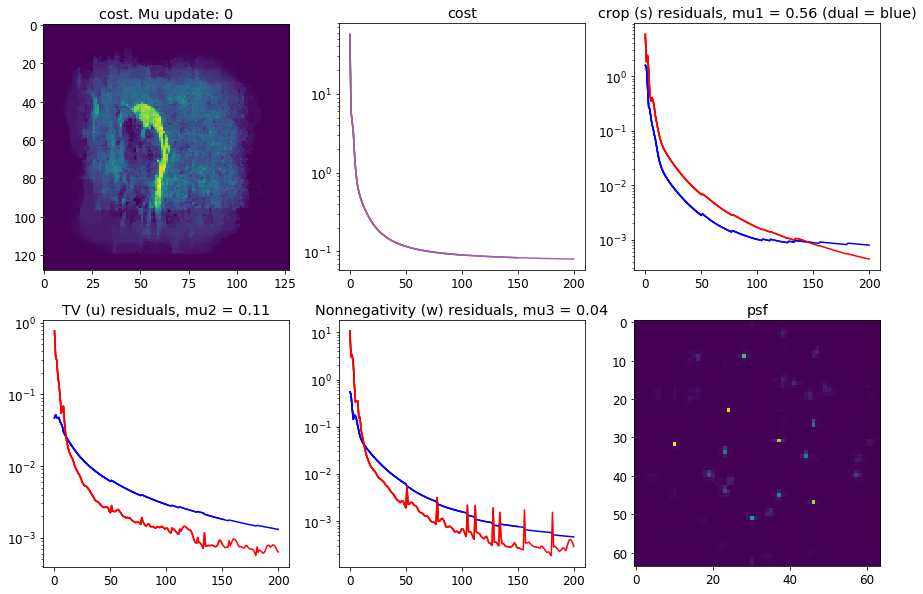

In [119]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
tau_m = np.mean(tau_b[-1])
iters_m = 201
mu1_m = np.mean(mu1_b)
mu2_m = np.mean(mu2_b)
mu3_m = np.mean(mu3_b)

# ag_utils.admm2d_learn(np.squeeze(meas_b[n,:,:]),psf_b,tau_i, iters, mu1_i, mu2_i, mu3_i, options = ag_utils.gen_options(disp_interval = 1, fig_size = (20,20)))
# test = ag_utils.admm2d(np.squeeze(meas_i[n,:,:]),psf_i,tau_m, iters_m, options = ag_utils.gen_options(mu1 = mu1_m, mu2 = mu2_m, mu3 = mu3_m, disp_interval = 100))
ag_utils.admm2d(np.squeeze(meas_b[n,:,:]),psf_b,tau_m, iters_m, options = ag_utils.gen_options(mu1 = mu1_m, mu2 = mu2_m, mu3 = mu3_m, resid_tol = 3, disp_interval = 50, fig_size = (15,10)))
# recon_m_b = [ag_utils.admm2d(np.squeeze(meas_b[n,:,:]),psf_b,tau_m, iters_m, options = ag_utils.gen_options(mu1 = mu1_m, mu2 = mu2_m, mu3 = mu3_m)) for n in range(meas_i.shape[0])]

array([[ 5.02578645e-03,  4.22885617e-03,  7.38454807e-03, ...,
         6.81007931e-03,  8.49626916e-03,  6.54167696e-03],
       [ 5.40762713e-03,  2.80860364e-03,  3.49530922e-03, ...,
         5.19936912e-03,  8.32945635e-03,  6.63140879e-03],
       [ 2.86085189e-03, -1.01272207e-03,  9.04039296e-05, ...,
         3.93900286e-03,  5.35384761e-03,  5.41696740e-03],
       ...,
       [-8.24388272e-04, -3.34685802e-03, -4.06658540e-03, ...,
         6.41296522e-03,  5.93925073e-03,  1.10941457e-03],
       [ 4.55796344e-05, -1.16201602e-04, -3.85145801e-04, ...,
         7.18545347e-03,  5.74569538e-03,  1.05675505e-03],
       [-3.62881819e-03, -4.09766804e-03, -4.04206031e-04, ...,
         3.32846027e-03,  1.90865049e-03, -2.13131008e-03]])

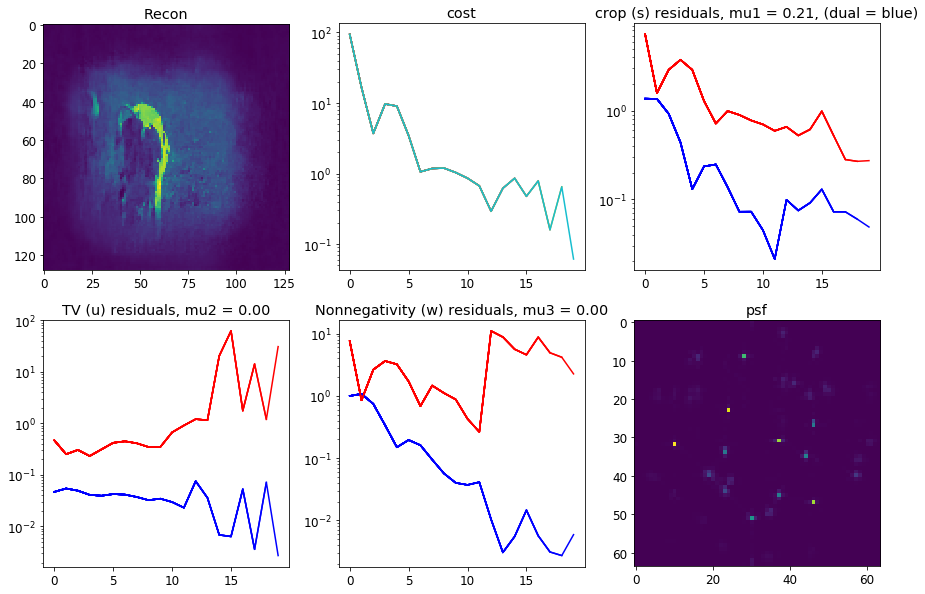

In [90]:
ag_utils.admm2d_learn(np.squeeze(meas_b[n,:,:]),psf_b,tau_b, iters, mu1_b, mu2_b, mu3_b, options = ag_utils.gen_options(disp_interval = 1, fig_size = (15,10)))

In [50]:
ag_utils.admm2d?


In [126]:
fig.savefig('../colearned_128grid_noisevar_noiseTrained_0.png')

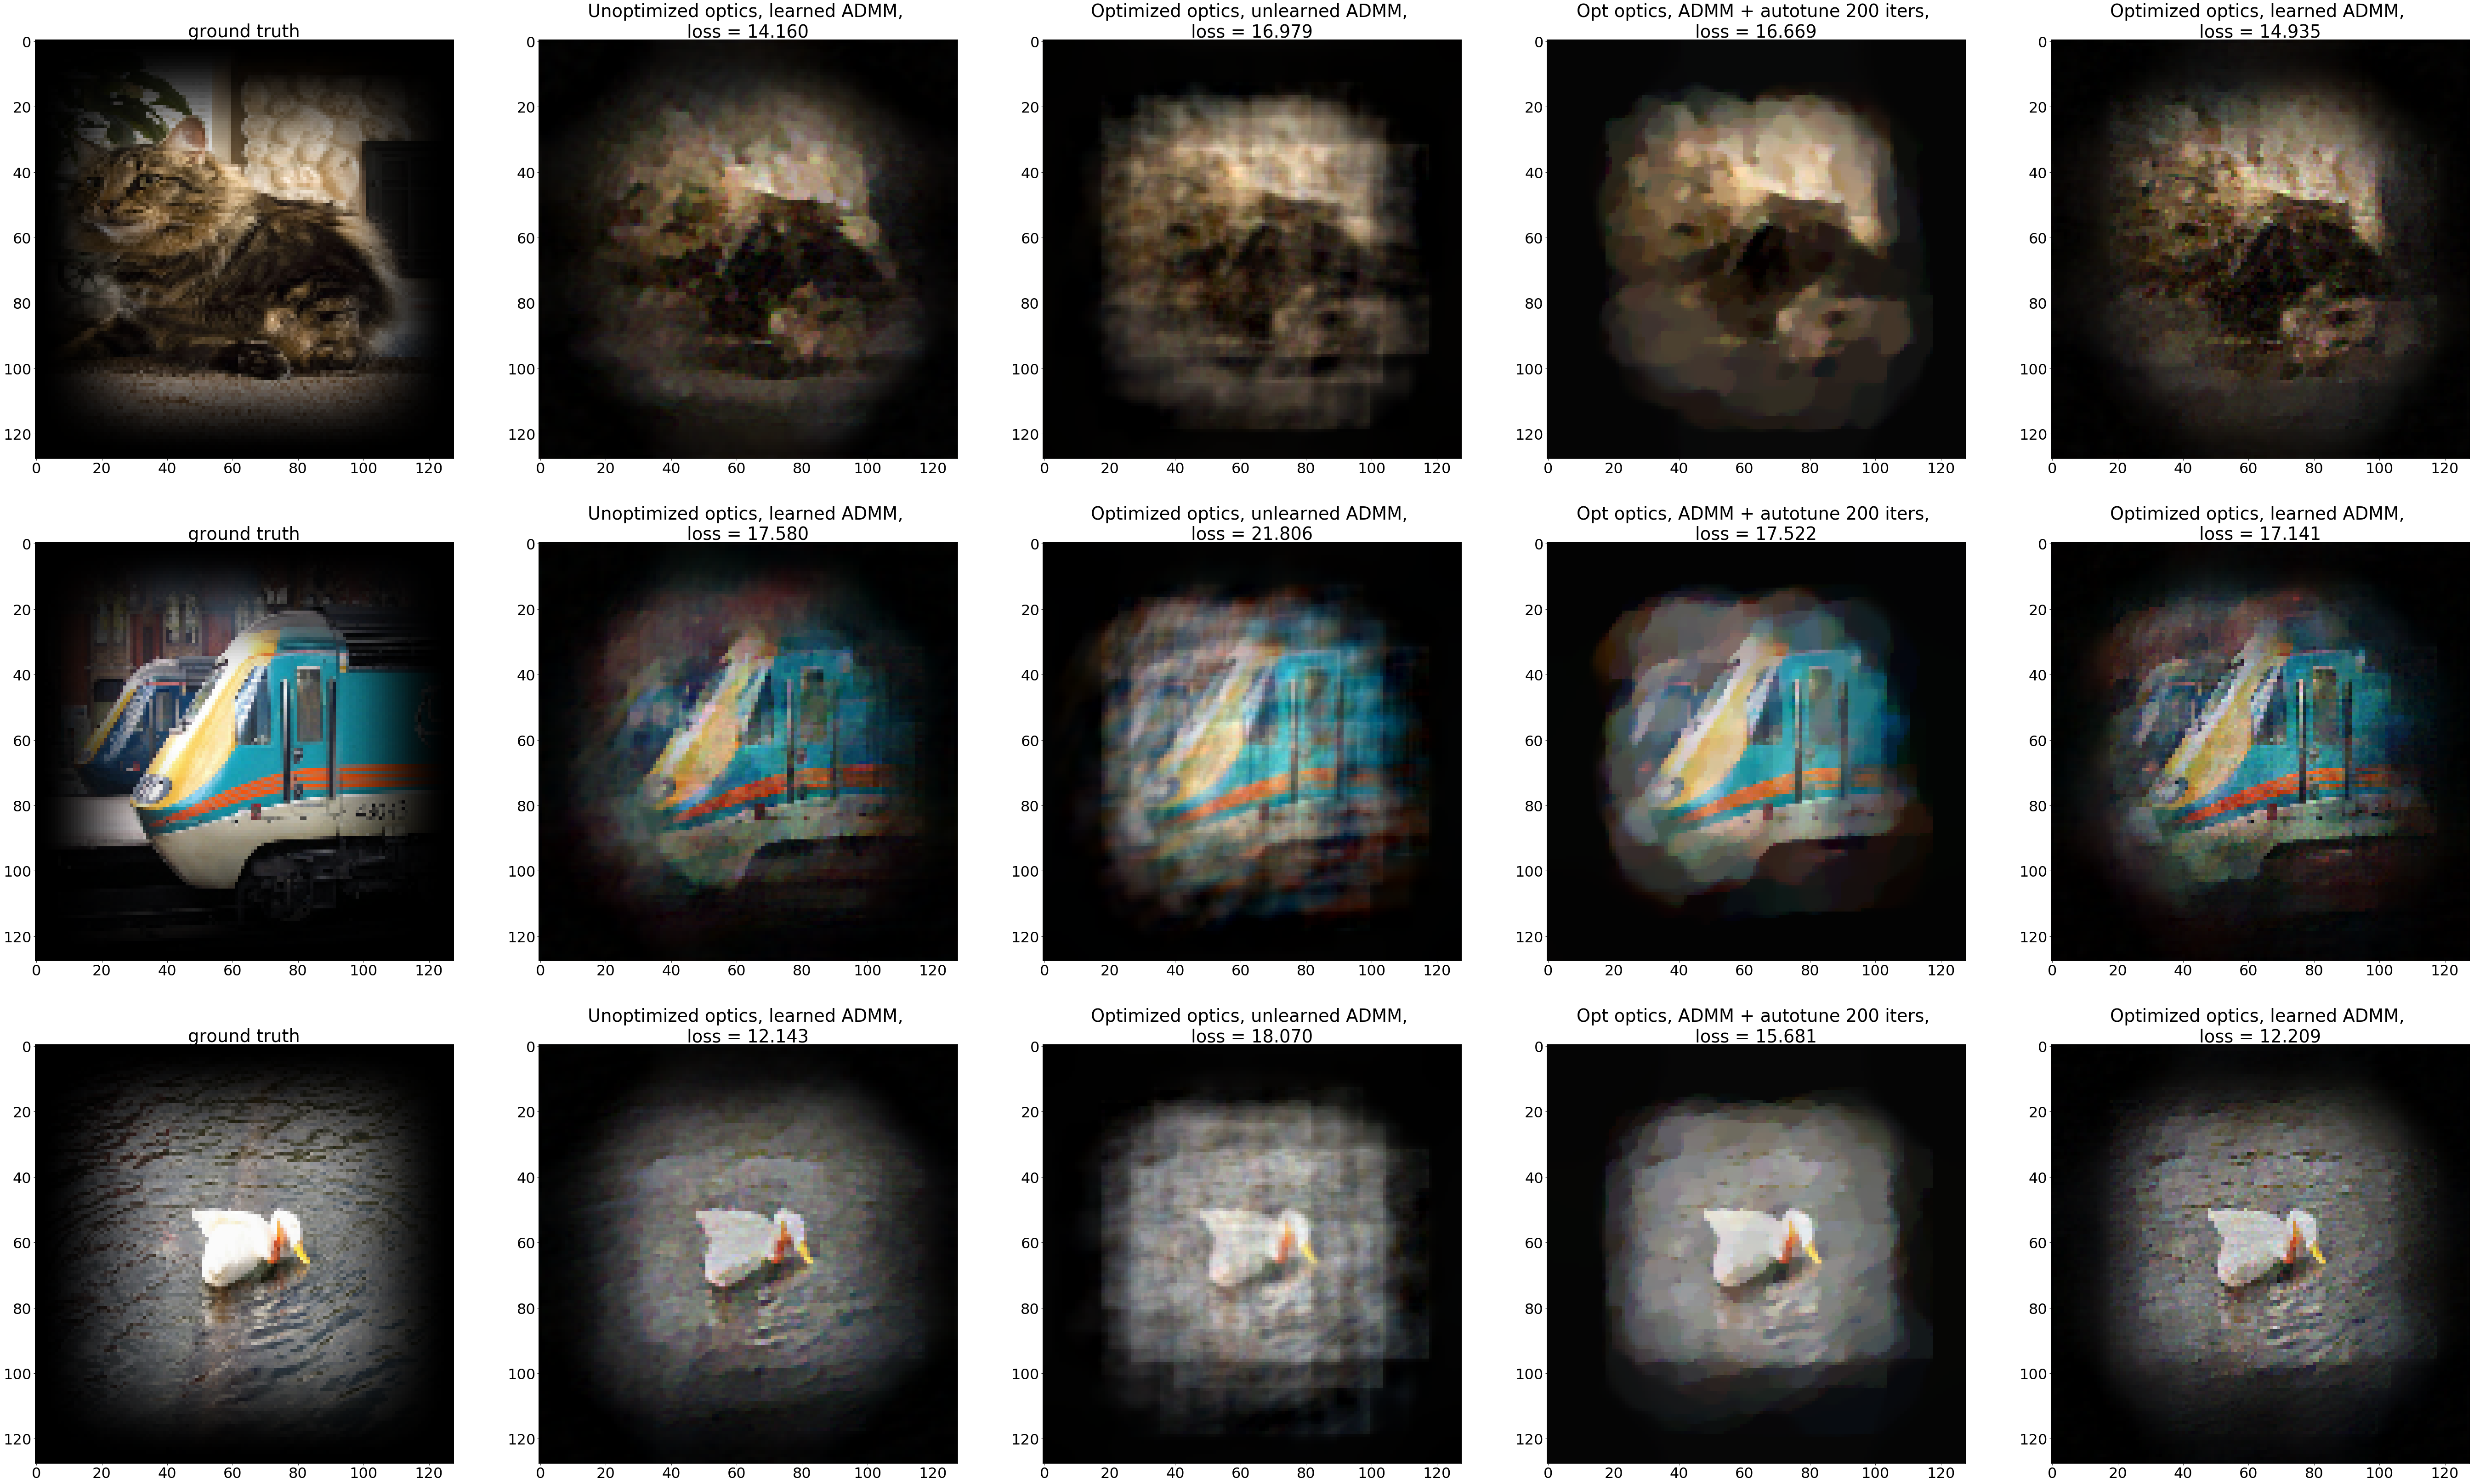

In [146]:
fs = 19
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 32}


plt.rc('font', **font)
nim = 3
fig, ax = plt.subplots(nim,5, figsize = (fs*5, fs*nim))
for nn in range(len(val_list[:(nim)])):
    ax[nn,0].imshow(rgb2imshow(val_list[nn]))
    ax[nn,0].set_title('ground truth')
#     ax[nn,1].imshow(rgb2imshow(recon_i[nn]))
#     ax[nn,1].set_title('Unoptimized optics, unlearned ADMM, \nloss = %.3f' %loss_i[nn])
    ax[nn,1].imshow(rgb2imshow(recon_ladmm[nn]))
    ax[nn,1].set_title('Unoptimized optics, learned ADMM, \nloss = %.3f' %loss_ladmm[nn])
    ax[nn,2].imshow(rgb2imshow(recon_opt[nn]))
    ax[nn,2].set_title('Optimized optics, unlearned ADMM, \nloss = %.3f' %loss_opt[nn])
    ax[nn,3].imshow(rgb2imshow(recon_m[nn]))
    ax[nn,3].set_title('Opt optics, ADMM + autotune %i iters, \nloss = %.3f' %(iters_m, loss_m[nn]))
    ax[nn,4].imshow(rgb2imshow(recon_b[nn]))
    ax[nn,4].set_title('Optimized optics, learned ADMM, \nloss = %.3f' %loss_b[nn])

#ag_utils.forward_sim?

# Do recon

In [147]:
fig.savefig('../colearned_128grid_4slides_noisevar_noiseTrained_0_convergedadmm_besttau.png')

In [99]:
print(np.max(meas_b[:]))

0.6320487037869892


In [ ]:
lsurf = ag_utils.make_lenslet_surface_ag

In [ ]:
lsurf = ag_utils.make_lenslet_surface_ag